In [7]:
!pip install tensorflow==2.5.0

     |████████████████████████████████| 195.7 MB 159 kB/s              
     |████████████████████████████████| 15.6 MB 14.4 MB/s            
     |████████████████████████████████| 1.2 MB 44.8 MB/s            
     |████████████████████████████████| 132 kB 21.8 MB/s            
     |████████████████████████████████| 2.9 MB 57.1 MB/s            
     |████████████████████████████████| 3.7 MB 43.9 MB/s            
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Preparing metadata (setup.py) ... done
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 5.8 MB 34.3 MB/s            
     |████████████████████████████████| 961 kB 32.4 MB/s            
     |███████████████████

In [8]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
tfd = tfp.distributions

from tqdm import tqdm_notebook as tqdm

import seaborn as sns

ModuleNotFoundError: No module named 'tensorflow_probability'

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [ ]:
heterogeneous = True

if heterogeneous:
    # heterogeneous degree graph
    sizes = [75, 75, 300]
    probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]
    G = nx.stochastic_block_model(sizes, probs, seed=0)
else:
    # homogeneous degree graph
    sizes = [300, 300]
    probs = [[0.25, 0.05, ], [0.05, 0.25,], ]
    G = nx.stochastic_block_model(sizes, probs, seed=0)

In [9]:
B=nx.adjacency_matrix(G)
sparse_A = convert_sparse_matrix_to_sparse_tensor(B.astype('float32'))

NameError: name 'nx' is not defined

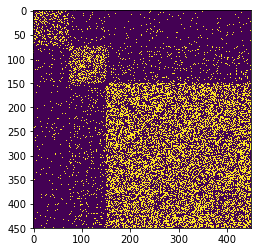

In [5]:
plt.imshow(B.todense())
plt.show()

In [6]:
def take_upper_triangular_wo_diagonal(A):

    ones = tf.ones_like(A)
    mask_a = tf.linalg.band_part(ones, 0, -1) # Upper triangular matrix of 0s and 1s
    mask_b = tf.linalg.band_part(ones, 0, 0)  # Diagonal matrix of 0s and 1s
    mask = tf.cast(mask_a - mask_b, dtype=tf.bool) # Make a bool mask

    upper_triangular_flat = tf.boolean_mask(A, mask)
    
    return upper_triangular_flat

def log_joint_probability_onehot(Z, C, A):
    """
    @Z: matrix of shape (N, C)
    @C: matrix of shape (C, C)
    @A: matrix of shape (N, N), observed adj matrix
    """
    ZC = Z@C
    A_probs = ZC@tf.transpose(Z)
    
    A_tri = take_upper_triangular_wo_diagonal(tf.cast(A, "float32"))
    A_p_tri = take_upper_triangular_wo_diagonal(A_probs)

    return tf.reduce_sum(A_tri * tf.math.log(A_p_tri) + (1.-A_tri) * tf.math.log(1.-A_p_tri))

def pop_element_i(tensor, i):
    return tf.concat([tensor[:i], tensor[i+1:]], axis=0)

def flip_one_z(Z, C, A, i):
    """
    @Z: matrix of shape (N, C)
    @C: matrix of shape (C, C)
    @A: matrix of shape (N, N), observed adj matrix
    @i: which node to flip
    """
    # get the probability
    class_logits = []
    K = tf.shape(Z)[1]
    A_i = A[i, :][None, :]
    A_i = pop_element_i(A_i, i)
    
    for k in range(K):
        zk = tf.one_hot(k, K)[None, :]
        A_p_k = (zk@C)@tf.transpose(Z)
        A_p_k = pop_element_i(A_p_k, i)
        
        pos_logp = tf.reduce_sum(tf.math.log(A_p_k) * A_i) # include self node
        neg_logp = tf.reduce_sum(tf.math.log(1-A_p_k)*(1-A_i)) # don't include self node
        
        A_logit_k = pos_logp + neg_logp
        class_logits.append(A_logit_k)
    
    raw_p = tf.concat(class_logits, axis=0)
    norm_p = tf.nn.softmax(class_logits)
    
    new_k = tfd.Categorical(probs=norm_p).sample()
    new_z = tf.scatter_nd(indices = [[i, new_k]], updates = [1., ], shape=tf.shape(Z))
    
    mask = tf.one_hot(i, tf.shape(Z)[0])[:, None]
    return new_z * mask + Z * (1-mask)

def bp_one_z(Z, C, A, i):
    """
    @Z: matrix of shape (N, C)
    @C: matrix of shape (C, C)
    @A: matrix of shape (N, N), observed adj matrix
    @i: which node to flip
    """
    # get the probability
    class_logits = []
    K = tf.shape(Z)[1]
    A_i = A[i, :][None, :]
    A_i = pop_element_i(A_i, i)
    
    for k in range(K):
        zk = tf.one_hot(k, K)[None, :]
        A_p_k = (zk@C)@tf.transpose(Z)
        A_p_k = pop_element_i(A_p_k, i)
        
        pos_logp = tf.reduce_sum(tf.math.log(A_p_k) * A_i) # include self node
        neg_logp = tf.reduce_sum(tf.math.log(1-A_p_k)*(1-A_i)) # don't include self node
        
        A_logit_k = pos_logp + neg_logp
        class_logits.append(A_logit_k)
    
    raw_p = tf.concat(class_logits, axis=0)
    new_k = tf.cast(tf.argmax(class_logits), 'int32')
    
    new_z = tf.scatter_nd(indices = [[i, new_k]], updates = [1., ], shape=tf.shape(Z))
    
    mask = tf.one_hot(i, tf.shape(Z)[0])[:, None]
    return new_z * mask + Z * (1-mask)

In [7]:
def rearrange_by_membership(A, Z):
    N, K = tf.shape(Z)
    sorted_Z = []
    
    for k in range(K):
        sorted_Z.append(tf.range(N)[tf.argmax(Z, axis=-1)==k])
    sorted_Z = tf.concat(sorted_Z, axis=-1)
    
    return A.numpy()[sorted_Z.numpy(), :][:, sorted_Z.numpy()]

In [8]:
tf_p = tf.constant(probs)
dense_A = tf.sparse.to_dense(sparse_A)

N = sum(sizes)
T = 50
Z = tf.cast(tfd.OneHotCategorical(logits=tf.ones((len(sizes),))).sample((N)), "float32")
logp_record = [log_joint_probability_onehot(Z, tf_p, dense_A).numpy(),]

for t in tqdm(range(T)):
    order = tf.random.shuffle(tf.range(N))
    
    for i in order:
        Z = flip_one_z(Z, tf_p, dense_A, i)
    logp_record.append(log_joint_probability_onehot(Z, tf_p, dense_A).numpy())

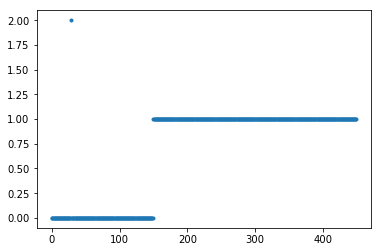

In [12]:
plt.plot(tf.argmax(Z, axis=-1), '.')

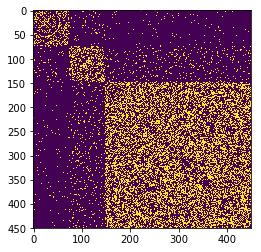

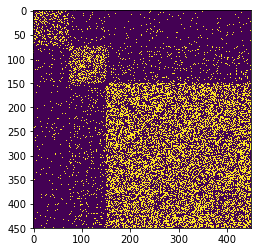

In [13]:
plt.imshow(rearrange_by_membership(dense_A, Z))
plt.show()
plt.imshow(dense_A)

In [18]:
def calculate_dZ(Z, C, A):
    Z_param = tf.Variable(Z, trainable=True)

    with tf.GradientTape() as tape:
        ll = log_joint_probability_onehot(Z_param, C, A)

    dZ = tape.gradient(ll, Z_param)
    
    return dZ

def dtilde(Z, dZ):
    return dZ - tf.reduce_sum(Z*dZ, axis=-1, keepdims=True)

def dtilde_exact(Z, C, A):
    array = Z.numpy()
    res = np.zeros_like(array)
    cur_log_joint = log_joint_probability_onehot(array, C, A)
    
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i, j] != 1.:
                empty = np.zeros_like(array[i, :])
                empty[j] = 1.
                array_p = array.copy()
                array_p[i, :] = empty
                
                ll = log_joint_probability_onehot(array_p, C, A) - cur_log_joint
                res[i, j] = ll
    
    return res

def plot_probs(df, Z, splits = 9, act = tf.nn.softmax):
    popped_logits = tf.boolean_mask(df/2, 1-Z)
    print(popped_logits.shape)
    # sample
    rv = tfd.OneHotCategorical(logits=popped_logits)
    sample = rv.sample() # this will be 1 dim
    logp = rv.log_prob(sample)

    data = (act(popped_logits, axis=-1))
    data = tf.split(data.numpy().reshape((-1, 2)), splits)
    vmin = tf.reduce_min(data).numpy()
    vmax = tf.reduce_max(data).numpy()

    f, ax = plt.subplots( ncols= splits, figsize=(12,8))
    for s in range(splits):
        ax[s].imshow(data[s], vmin= vmin, vmax=vmax)
    plt.show()
    
    return data

In [19]:
df_exact = dtilde_exact(Z, tf_p, dense_A)
dZ = calculate_dZ(Z, tf_p, dense_A)
df = dtilde(Z, dZ) 

(900,)


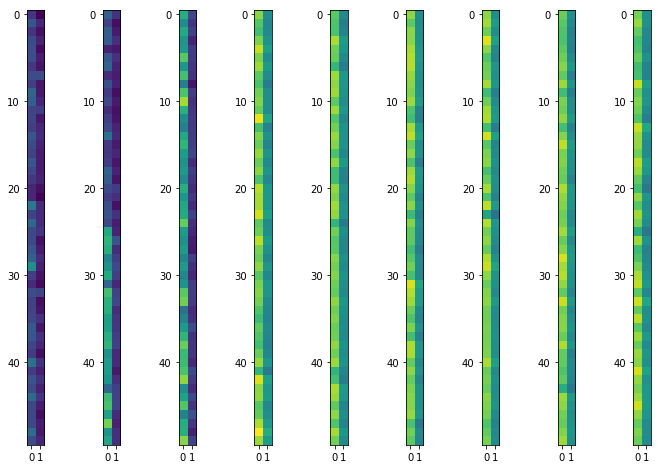

In [20]:
diff = plot_probs(df-df_exact, Z, act = lambda x, axis: tf.identity(x))

In [22]:
def plot_target_class_based_residual(diff):
    residuals = []
    
    for c in range(diff.shape[1]):
        x = diff[:, c]
        masked_x = x[x!=0]
        
        residuals.append(masked_x)
    
    return residuals

def plot_target_origin_based_residual(diff):
    residuals = {'{}_to_{}'.format(c, d):[] for c in range(diff.shape[1])\
                 for d in range(diff.shape[1]) if c!=d}
    
    for i in range(diff.shape[0]):
        x = diff[i, :]
        c = np.where(x==0)[0][0]
        
        for j in range(diff.shape[1]):
            if j != c:
                residuals['{}_to_{}'.format(c, j)].append(x[j])
    
    return {k: np.array(residuals[k], dtype='float32') for k in residuals}

def plot_target_origin_based_residual(diff):
    residuals = {'{}_to_{}'.format(c, d):[] for c in range(diff.shape[1])\
                 for d in range(diff.shape[1]) if c!=d}
    
    for i in range(diff.shape[0]):
        x = diff[i, :]
        c = np.where(x==0)[0][0]
        
        for j in range(diff.shape[1]):
            if j != c:
                residuals['{}_to_{}'.format(c, j)].append(x[j])
    
    return {k: np.array(residuals[k], dtype='float32') for k in residuals}

def calculate_majority(a):
    counts = np.bincount(a)
    return(np.argmax(counts))

def plot_target_origin_majority_based_residual(diff, A, ):
    residuals = {'{}_to_maj'.format(c, ):[] for c in range(diff.shape[1])}
    residuals.update({'{}_to_min'.format(c, ):[] for c in range(diff.shape[1])})
    Z = tf.cast(diff==0, 'float32')
    
    for i in range(diff.shape[0]):
        x = diff[i, :]
        c = np.where(x==0)[0][0]
        
        nbs = tf.boolean_mask(Z, A[:, i])
        nb_zs = tf.argmax(nbs, axis=1)
        maj = calculate_majority(nb_zs)
        
        for j in range(diff.shape[1]):
            if j != c:
                if j == maj:
                    residuals['{}_to_maj'.format(c, j)].append(x[j])
                else:
                    residuals['{}_to_min'.format(c, j)].append(x[j])
    
    return {k: np.array(residuals[k], dtype='float32') for k in residuals}

def plot_target_origin_majority_based_residual(diff, A, ):
    residuals = {'{}_to_maj'.format(c, ):[] for c in range(diff.shape[1])}
    residuals.update({'{}_to_min'.format(c, ):[] for c in range(diff.shape[1])})
    Z = tf.cast(diff==0, 'float32')
    
    for i in range(diff.shape[0]):
        x = diff[i, :]
        c = np.where(x==0)[0][0]
        
        nbs = tf.boolean_mask(Z, A[:, i])
        nb_zs = tf.argmax(nbs, axis=1)
        maj = calculate_majority(nb_zs)
        
        for j in range(diff.shape[1]):
            if j != c:
                if j == maj:
                    residuals['{}_to_maj'.format(c, j)].append(x[j])
                else:
                    residuals['{}_to_min'.format(c, j)].append(x[j])
    
    return {k: np.array(residuals[k], dtype='float32') for k in residuals}

def split_residual4(diff, A, ):
    residuals = {'{}_to_maj'.format(c, ):dict() for c in range(diff.shape[1])}
    residuals.update({'{}_to_min'.format(c, ):dict() for c in range(diff.shape[1])})
    Z = tf.cast(diff==0, 'float32')
    
    for i in range(diff.shape[0]):
        x = diff[i, :]
        c = np.where(x==0)[0][0]
        
        nbs = tf.boolean_mask(Z, A[:, i])
        nb_zs = tf.argmax(nbs, axis=1)
        maj = calculate_majority(nb_zs)
        
        for j in range(diff.shape[1]):
            if j != c:
                if j == maj:
                    try:
                        residuals['{}_to_maj'.format(c,)][str(j)].append(x[j])
                    except:
                        residuals['{}_to_maj'.format(c,)][str(j)] = [x[j],]
                else:
                    try:
                        residuals['{}_to_min'.format(c, j)][str(j)].append(x[j])
                    except:
                        residuals['{}_to_min'.format(c,)][str(j)] = [x[j],]
    
    return residuals

In [23]:
residuals1 = plot_target_class_based_residual(df-df_exact)
residuals2 = plot_target_origin_based_residual(df-df_exact)
residuals3 = plot_target_origin_majority_based_residual(df-df_exact, dense_A)
residuals4 = split_residual4(df-df_exact, dense_A)

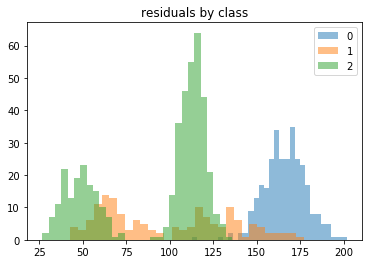

In [33]:
residuals1 = plot_target_class_based_residual(df-df_exact)
for i, r in enumerate(residuals1):
    plt.hist(r, label=str(i),bins=30, alpha=0.5)

plt.title('residuals by class')
plt.legend()
plt.show()

/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


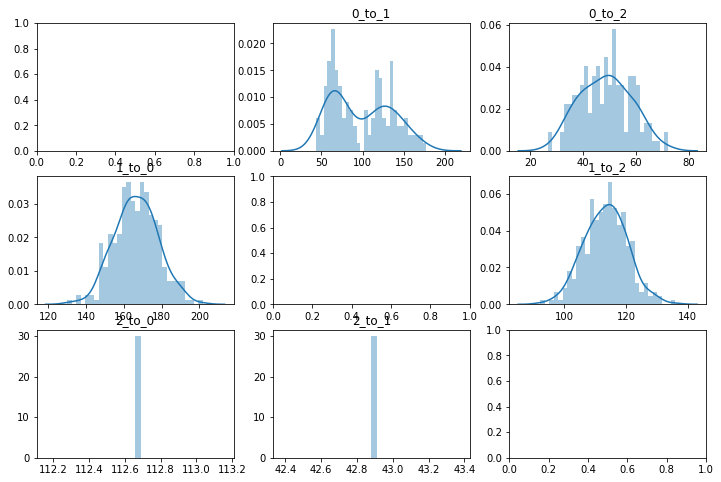

In [30]:
fig,ax = plt.subplots(ncols=3, nrows=3, figsize=(12,8))
for k in residuals2:
    i = int(k[0])
    j = int(k[-1])
    sns.distplot(residuals2[k], hist=True,bins=30,ax=ax[i, j])
    ax[i, j].title.set_text(k)
    
plt.show()

/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


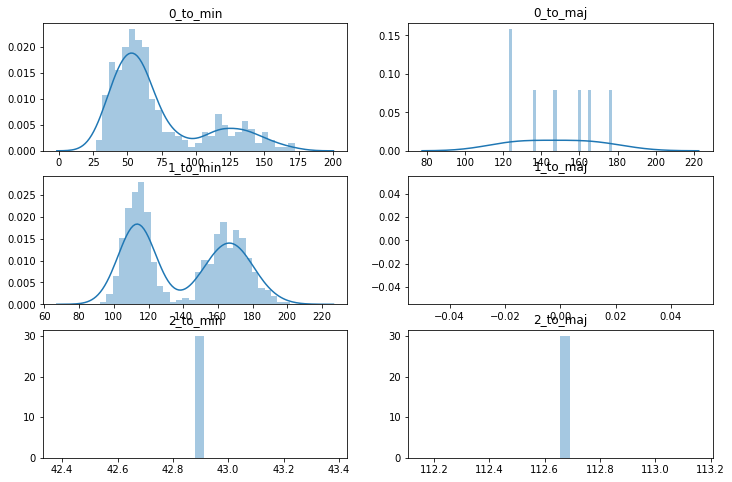

In [29]:
fig,ax = plt.subplots(ncols=2, nrows=3, figsize=(12,8))
to_col = {'min':0, 'maj':1}
for k in residuals3:
    i = int(k[0])
    j = k[-3:]
    sns.distplot(residuals3[k], hist=True,bins=30,ax=ax[i, to_col[j]])
    ax[i, to_col[j]].title.set_text(k)
    
plt.show()

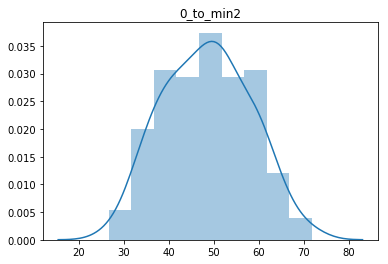

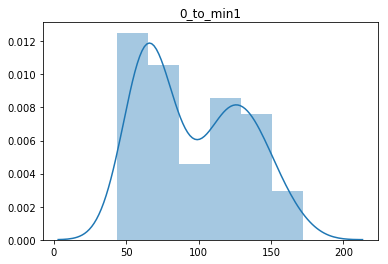

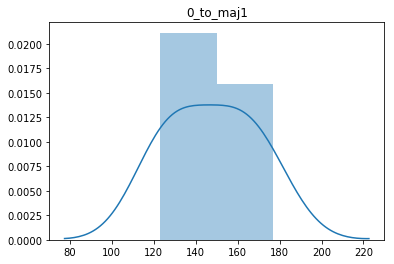

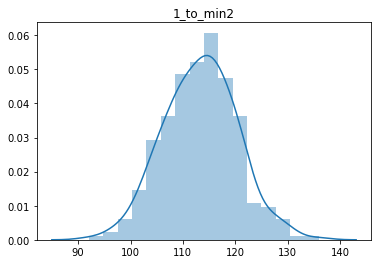

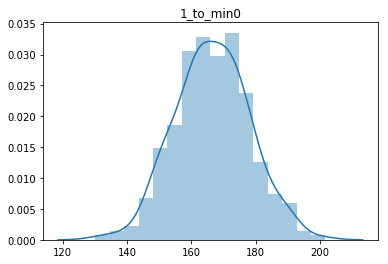

/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


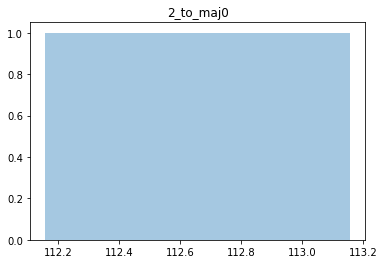

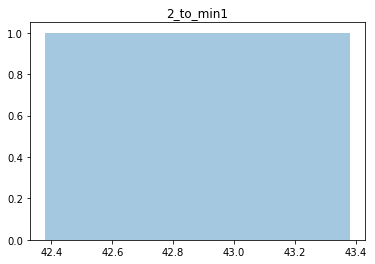

In [26]:
for k in residuals4:
    for k2 in residuals4[k]:
        sns.distplot(residuals4[k][k2], hist=True)
        plt.title(k + k2)
        plt.show()

/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


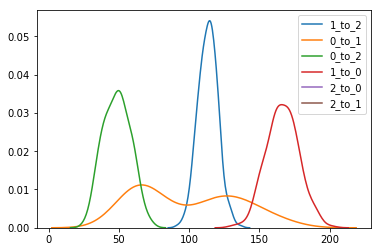

In [27]:
for k in residuals2:
    sns.distplot(residuals2[k], label=k, hist=False)

plt.legend()
plt.show()

/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/donghanhe/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


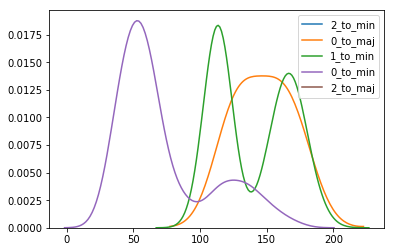

In [28]:
for k in residuals3:
    sns.distplot(residuals3[k], label=k, hist=False)

plt.legend()
plt.show()

let's do before and after 1 step of GWG

In [39]:
def GWG_SBM_step(Z, C, A):
    dZ = calculate_dZ(Z, C, A)
    df = dtilde(Z, dZ) 
    
    flipped_one, logp_fw, flatten_change = sample_with_logprob_and_change(df/2, Z)
    flip_mask = tf.reduce_sum(flipped_one, axis=-1, keepdims=True)
    Zp = flipped_one * flip_mask + (1.-flip_mask)*Z
    
    dZp = calculate_dZ(Zp, C, A)
    dfp = dtilde(Zp, dZp)
    
    masked_Z = tf.boolean_mask(Z, 1-Zp)
    masked_logits = tf.boolean_mask(dfp/2, 1-Zp)
    logp_bw = tfd.OneHotCategorical(logits = masked_logits)\
                .log_prob(find_reverse_change(masked_Z, flatten_change))
        
    logprob_ratio = tf.reduce_sum(log_joint_probability_onehot(Zp, C, A)) \
                    - tf.reduce_sum(log_joint_probability_onehot(Z, C, A)) \
                    + logp_fw - logp_bw
    
    accept = tf.cast(tf.random.uniform(()) < tf.minimum(1., tf.exp(logprob_ratio)), 'float32')
    Z_new = accept * Zp + (1-accept) * Z
    
    return Z_new

def sample_with_logprob_and_change(logits, Z,):
    # first pop out the unneccesary ones
    popped_logits = tf.boolean_mask(logits, 1-Z)
    # sample
    rv = tfd.OneHotCategorical(logits=popped_logits)
    sample = rv.sample() # this will be 1 dim
    logp = rv.log_prob(sample)
    
    # now we need to assemble together the result
    Z_new = tf.scatter_nd(indices=tf.cast(tf.where(1-Z), 'int32'), 
                          updates=sample,
                          shape=tf.shape(Z))
    
    return tf.cast(Z_new, 'float32'), logp, sample

def find_reverse_change(masked_Z, flatten_change):
    # find changed dimension
    changed_dim = tf.reduce_sum(tf.reshape(flatten_change, tf.shape(masked_Z)), 
                                axis=-1, keepdims=True)
    rev_Z = masked_Z * tf.cast(changed_dim, "float32")
    
    return tf.reshape(rev_Z, (-1, ))

def find_change(Znew, Z):
    Cnew = tf.argmax(Znew, axis=1)
    C = tf.argmax(Z, axis=1)
    delta = tf.argmax(tf.logical_not(tf.equal(C, Cnew)))
    
    return delta, C[delta], Cnew[delta]

Let's run GWG for T iterations, and see how the distribution changes

In [246]:
T = 200
residuals_list = []
Z = tf.cast(tfd.OneHotCategorical(logits=tf.ones((len(sizes),))).sample((N)), "float32")

for t in tqdm(range(T)):
    # calculate stuff
    df_exact = dtilde_exact(Z, tf_p, dense_A)
    dZ = calculate_dZ(Z, tf_p, dense_A)
    df = dtilde(Z, dZ) 
    residuals_list.append(plot_target_class_based_residual(df-df_exact))
    
    Z = GWG_SBM_step(Z, tf_p, dense_A, )

In [247]:
df_exact = dtilde_exact(Z, tf_p, dense_A)
dZ = calculate_dZ(Z, tf_p, dense_A)
df = dtilde(Z, dZ) 
residuals_list.append(plot_target_class_based_residual(df-df_exact))

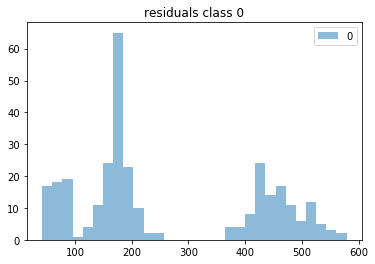

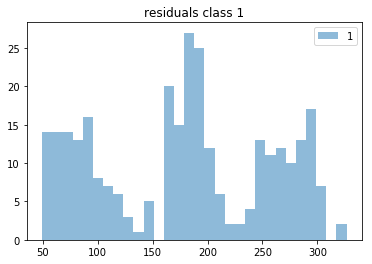

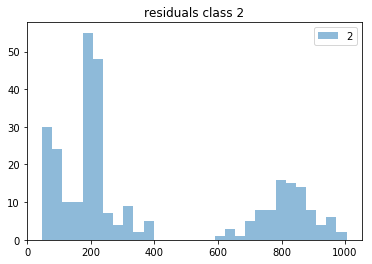

In [59]:
df_exact = dtilde_exact(Z, tf_p, dense_A)
dZ = calculate_dZ(Z, tf_p, dense_A)
df = dtilde(Z, dZ) 

residuals1 = plot_target_class_based_residual(df-df_exact)
for i, r in enumerate(residuals1):
    plt.hist(r, label=str(i),bins=30, alpha=0.5)

    plt.title('residuals class {}'.format(i))
    plt.legend()
    plt.show()

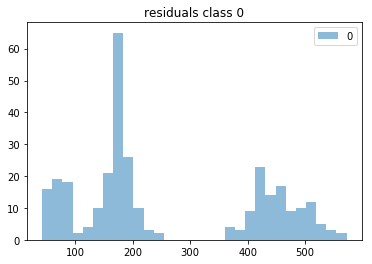

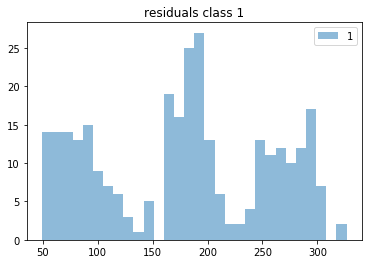

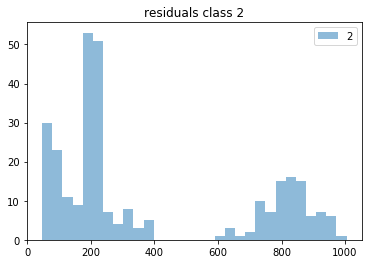

In [60]:
Znew = GWG_SBM_step(Z, tf_p, dense_A, )

df_exact = dtilde_exact(Znew, tf_p, dense_A)
dZ = calculate_dZ(Znew, tf_p, dense_A)
df = dtilde(Znew, dZ) 

residuals1new = plot_target_class_based_residual(df-df_exact)
for i, r in enumerate(residuals1new):
    plt.hist(r, label=str(i),bins=30, alpha=0.5)

    plt.title('residuals class {}'.format(i))
    plt.legend()
    plt.show()

In [87]:
import pandas as pd
import plotly.express as px

In [111]:
def get_class(res_list, c):
    out = []
    
    for t, r in enumerate(res_list):
        rc = r[c]
        rt = np.ones_like(rc) * t
        
        to_append = np.zeros((len(rc), 2))
        to_append[:, 0] = rc
        to_append[:, 1] = rt
        
        out.append(to_append)
    
    return np.concatenate(out, axis= 0)

In [248]:
c = 0
class_res = get_class(residuals_list,c)
df = pd.DataFrame.from_dict({'residual class {}'.format(c):class_res[:, 0],
                             't': class_res[:, 1]})
px.histogram(df, x="residual class {}".format(c), animation_frame="t", nbins=50)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 't=0.0<br>residual class 0=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa'},
              'name': '',
              'nbinsx': 50,
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'histogram',
              'x': array([ 36.68854523, 182.94340515,  46.61281586, ..., 197.49101257,
                          487.25061035, 498.19378662]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'frames': [{'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=0.0<br>residual class 0=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 36.68854523, 182.94340515,  46.61281586, ..., 197.49101257,
                                      487.25061035, 498.19378662]),
                          'xaxis': 'x',
                          'yaxis': 'y'}],
                'name': '0.0'},
               {'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=1.0<br>residual class 0=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 36.66377258, 183.05361938,  46.58804321, ..., 197.46624756,
                                      487.35296631, 498.30395508]),
                          'xaxis': 'x',
                          'yaxis': 'y'}],
                'name': '1.0'},
               {'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=2.0<br>residual class 0=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 36.63118362, 183.15602112,  46.5632782 , ..., 197.43367004,
                                      487.46322632, 491.36965942]),
                          'xaxis': 'x',
                          'yaxis': 'y'}],
                'name': '2.0'},
               {'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=3.0<br>residual class 0=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 36.61421967, 183.27404785,  46.53849792, ..., 197.41668701,
                                      487.57342529, 491.4798584 ]),
                          'xaxis': 'x',
                          'yaxis': 'y

In [249]:
c = 1
class_res = get_class(residuals_list,c)
df = pd.DataFrame.from_dict({'residual class {}'.format(c):class_res[:, 0],
                             't': class_res[:, 1]})
px.histogram(df, x="residual class {}".format(c), animation_frame="t", nbins=50)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 't=0.0<br>residual class 1=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa'},
              'name': '',
              'nbinsx': 50,
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'histogram',
              'x': array([ 59.67808533,  56.1808548 ,  68.90093231, ..., 170.00567627,
                          176.06813049, 260.52398682]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'frames': [{'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=0.0<br>residual class 1=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 59.67808533,  56.1808548 ,  68.90093231, ..., 170.00567627,
                                      176.06813049, 260.52398682]),
                          'xaxis': 'x',
                          'yaxis': 'y'}],
                'name': '0.0'},
               {'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=1.0<br>residual class 1=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 59.78995514,  56.29271698,  68.87230682, ..., 170.11755371,
                                      176.17999268, 260.49536133]),
                          'xaxis': 'x',
                          'yaxis': 'y'}],
                'name': '1.0'},
               {'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=2.0<br>residual class 1=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 59.90181732,  56.39675903,  68.84368134, ..., 170.22940063,
                                      176.51126099, 260.45895386]),
                          'xaxis': 'x',
                          'yaxis': 'y'}],
                'name': '2.0'},
               {'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=3.0<br>residual class 1=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 60.0136795 ,  56.50862885,  68.81506348, ..., 170.34127808,
                                      176.62313843, 260.89956665]),
                          'xaxis': 'x',
                          'yaxis': 'y

In [250]:
c = 2
class_res = get_class(residuals_list,c)
df = pd.DataFrame.from_dict({'residual class {}'.format(c):class_res[:, 0],
                             't': class_res[:, 1]})
px.histogram(df, x="residual class {}".format(c), animation_frame="t", nbins=50)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 't=0.0<br>residual class 2=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa'},
              'name': '',
              'nbinsx': 50,
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'histogram',
              'x': array([ 51.78756332,  50.89884567,  69.27937317, ..., 227.31176758,
                          806.59466553, 803.02246094]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'frames': [{'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=0.0<br>residual class 2=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 51.78756332,  50.89884567,  69.27937317, ..., 227.31176758,
                                      806.59466553, 803.02246094]),
                          'xaxis': 'x',
                          'yaxis': 'y'}],
                'name': '0.0'},
               {'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=1.0<br>residual class 2=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 51.86989212,  50.98899078,  69.36952209, ..., 227.4019165 ,
                                      806.65802002, 803.08587646]),
                          'xaxis': 'x',
                          'yaxis': 'y'}],
                'name': '1.0'},
               {'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=2.0<br>residual class 2=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 51.95222473,  51.06351471,  69.44403076, ..., 227.48423767,
                                      806.72143555, 803.14923096]),
                          'xaxis': 'x',
                          'yaxis': 'y'}],
                'name': '2.0'},
               {'data': [{'alignmentgroup': 'True',
                          'bingroup': 'x',
                          'hovertemplate': 't=3.0<br>residual class 2=%{x}<br>count=%{y}<extra></extra>',
                          'legendgroup': '',
                          'marker': {'color': '#636efa'},
                          'name': '',
                          'nbinsx': 50,
                          'offsetgroup': '',
                          'orientation': 'v',
                          'showlegend': False,
                          'type': 'histogram',
                          'x': array([ 52.04236984,  51.15365601,  69.53417969, ..., 227.55874634,
                                      806.78485107, 817.54577637]),
                          'xaxis': 'x',
                          'yaxis': 'y

so this just means the mixture center drifts, steadily

In [127]:
from sklearn.mixture import GaussianMixture

In [251]:
def rearrange_by_sorted_order(gm, x):
    z = gm.predict(x)
    reorg = np.argsort(np.argsort(gm.means_[:, 0]))
    
    return [reorg[i] for i in z]

In [253]:
m_list = np.zeros((3, 3, T+1))
sorted_z_list = np.zeros((450, 3, T+1))


for t, res in enumerate(residuals_list):
    for i, r in enumerate(res):
        gm = GaussianMixture(n_components=3, random_state=0).fit(r[:, None])
        m_list[:, i, t] = np.sort(gm.means_[:, 0])

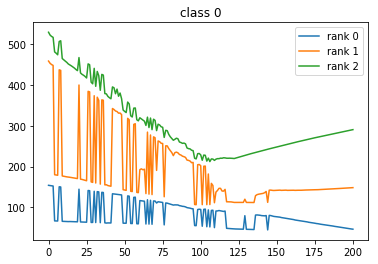

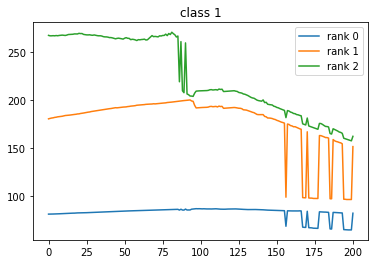

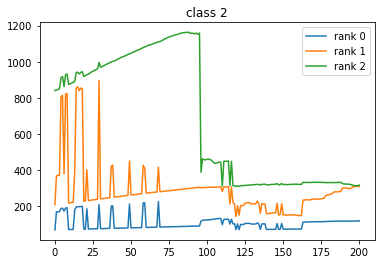

In [254]:
for c in range(3):
    for m in range(3):
        plt.plot(m_list[m, c, :], label='rank {}'.format(m))
    plt.title('class {}'.format(c))
    plt.legend()
    plt.show()

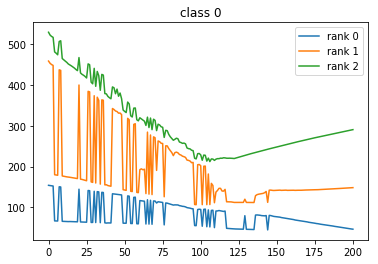

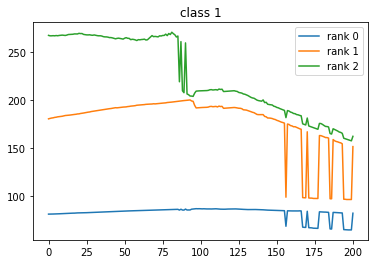

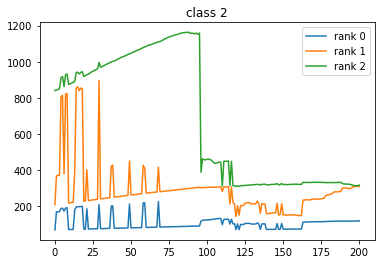

In [255]:
for c in range(3):
    for m in range(3):
        plt.plot(m_list[m, c, :], label='rank {}'.format(m))
    plt.title('class {}'.format(c))
    plt.legend()
    plt.show()

so let's just straightup fits a regression model on 1. class; 2. probability to

In [415]:
df_exact = dtilde_exact(Z, tf_p, dense_A)
dZ = calculate_dZ(Z, tf_p, dense_A)
df = dtilde(Z, dZ) 

residuals2 = plot_target_origin_based_residual(df-df_exact)

In [421]:
res = []
for k in residuals2:
    i = int(k[0])
    j = int(k[-1])
    tba = np.zeros((len(residuals2[k]), 3))
    tba[:, 0] = residuals2[k]
    tba[:, 1] = i * np.ones_like(residuals2[k])
    tba[:, 2] = j * np.ones_like(residuals2[k])
    res.append(tba)
    
pd_df = np.concatenate(res, axis=0)

In [422]:
train_x = np.concatenate([tf.one_hot(pd_df[:, 1], 3), tf.one_hot(pd_df[:, 2], 3), tf.ones((pd_df.shape[0], 1))], axis = 1)

In [431]:
def lin_reg_beta(x, y, lambd = 1e-3):
    pt1 = np.linalg.inv(x.T@x + lambd * np.eye(x.shape[1]))
    pt2 = x.T@y
    
    return pt1@pt2

def lin_reg_beta_pinv(x, y, lambd=1e-3):
    pt1 = np.linalg.pinv(x.T@x + lambd * np.eye(x.shape[1]))
    pt2 = x.T@y
    
    return pt1@pt2

ridge reg

In [434]:
beta = lin_reg_beta(train_x, pd_df[:, [0]])

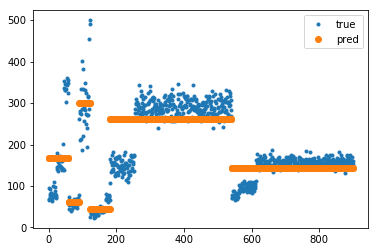

In [435]:
pred = train_x@beta
plt.plot(pd_df[:, 0], '.', label='true')
plt.plot(pred, 'o', label='pred')
plt.legend()
plt.show()

In [436]:
beta

array([[ 49.25262486],
       [-84.10033722],
       [132.61849998],
       [ 31.63958052],
       [-86.52716804],
       [152.65837514],
       [ 97.7707876 ]])

normal reg

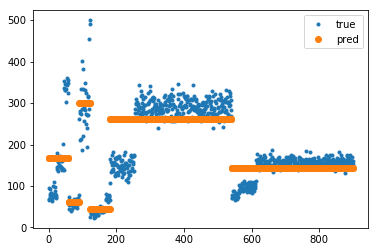

In [428]:
train_x = np.concatenate([tf.one_hot(pd_df[:, 1], 2), tf.one_hot(pd_df[:, 2], 2), tf.ones((pd_df.shape[0], 1))], axis = 1)
beta = lin_reg_beta(train_x, pd_df[:, [0]], lambd=0.)

pred = train_x@beta
plt.plot(pd_df[:, 0], '.', label='true')
plt.plot(pred, 'o', label='pred')
plt.legend()
plt.show()

pinv 

In [443]:
random_inds = np.random.choice(np.arange(900), size = (100, ), replace=False)

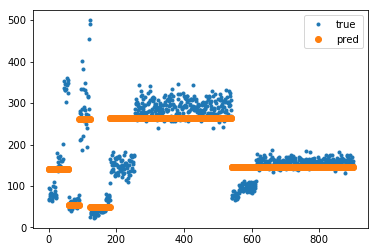

In [445]:
train_x = np.concatenate([tf.one_hot(pd_df[:, 1], 3), tf.one_hot(pd_df[:, 2], 3), tf.ones((pd_df.shape[0], 1))], axis = 1)
beta = lin_reg_beta_pinv(train_x[random_inds, :], pd_df[random_inds, [0]], lambd=0.)

pred = train_x@beta
plt.plot(pd_df[:, 0], '.', label='true')
plt.plot(pred, 'o', label='pred')
plt.legend()
plt.show()

In [446]:
beta

array([ 39.22381035, -80.20203129, 132.61045015,  38.96336406,
       -77.35987837, 130.02874351,  91.63222921])

In [613]:
beta[0] + beta[3+1], beta[0] + beta[3+2]

(-38.13606802313967, 169.252553859734)

take log then reg

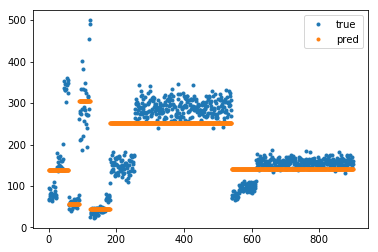

In [269]:
train_x = np.concatenate([tf.one_hot(df[:, 1], 2), tf.one_hot(df[:, 2], 2), tf.ones((df.shape[0], 1))], axis = 1)
beta = lin_reg_beta(train_x, np.log(df[:, [0]]), lambd=0.)

pred = np.exp(train_x@beta)
plt.plot(df[:, 0], '.', label='true')
plt.plot(pred, '.', label='pred')
plt.legend()
plt.show()

In [270]:
def calc_r2(y, ypred):
    ss_res = np.sum((y-ypred)**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    
    return 1-ss_res/ss_tot

In [271]:
calc_r2(df[:, [0]], pred)

0.6600923343086724

In [337]:
Z_param = tf.Variable(tf.reshape(Z, (-1,1)), trainable=True)

with tf.GradientTape() as tape:
    ll = log_joint_probability_onehot(tf.reshape(Z_param, (450, 3)), tf_p, dense_A)

dZ = tape.gradient(ll, Z_param)
dZ = tf.reshape(dZ, (450, 3))

In [294]:
tf.reshape(dZ, (450, 3))

<tf.Tensor: shape=(450, 3), dtype=float32, numpy=
array([[ 4.3134890e+00, -3.8356236e+01, -1.0280625e+02],
       [ 9.8320290e+01, -5.1704347e-02, -1.9871675e+02],
       [ 2.0410179e+01, -3.4123077e+01, -9.5398712e+01],
       ...,
       [-1.1565876e+01, -1.9267611e+01, -3.8276722e+01],
       [ 2.8836916e+01,  3.9311559e+00, -3.5323025e+01],
       [-5.3201022e+00,  2.6786154e+01, -4.1932648e+01]], dtype=float32)>

In [321]:
Z_param = tf.Variable(tf.reshape(Z, (-1,1)), trainable=True)
hess = []

with tf.GradientTape(persistent=True) as tape:
    ll = log_joint_probability_onehot(tf.reshape(Z_param, (450, 3)), tf_p, dense_A)
    grads = tape.gradient(ll, [Z_param, ])
    g0 = grads[0]
    
    for i in range(450*3):
        hess.append(tape.gradient(g0[i,:], [Z_param,]))

W1116 12:04:57.314452 4362640896 backprop.py:1029] Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
W1116 12:04:57.321305 4362640896 backprop.py:1029] Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.


In [319]:
grads

[<tf.Tensor: shape=(1350, 1), dtype=float32, numpy=
 array([[   4.313489],
        [ -38.356236],
        [-102.80625 ],
        ...,
        [  -5.320102],
        [  26.786154],
        [ -41.932648]], dtype=float32)>]

In [331]:
np_array = np.array([h[0].numpy() for h in hess], 'float32')[:, :, 0]

In [359]:
tf.one_hot(1,3)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>

In [375]:
def second_order_corr(flatten_Z, hess, orig_shape=(450,3)):
    N, C = orig_shape
    res = []
    Z = tf.reshape(flatten_Z, orig_shape)
    
    for i in range(N):
        c = tf.argmax(Z[i, :])
        
        for j in range(C):
            if j == c:
                res.append(0.)
            else:
                Zp = Z.numpy()
                Zp[i, :] = tf.one_hot(j, depth=C).numpy()
                flatten_Zp = Zp.flatten()[:, None]
                diff = flatten_Zp - flatten_Z
                corr = 0.5 * (diff.T@hess@diff)
                res.append(corr)
    
    return np.array(res, 'float32').reshape(orig_shape)

In [397]:
def second_order_corr_diag(flatten_Z, hess, orig_shape=(450,3)):
    N, C = orig_shape
    res = []
    Z = tf.reshape(flatten_Z, orig_shape)
    base = tf.transpose(flatten_Z)@hess@flatten_Z
    
    for i in range(N):
        c = tf.argmax(Z[i, :])
        
        for j in range(C):
            if j == c:
                res.append(0.)
            else:
                Zp = Z.numpy()
                Zp[i, :] = tf.one_hot(j, depth=C).numpy()
                flatten_Zp = Zp.flatten()[:, None]
                corr = 0.5 * (flatten_Zp.T@hess@flatten_Zp- base)
                res.append(corr)
    
    return np.array(res, 'float32').reshape(orig_shape)

In [398]:
soc = second_order_corr(Z_param.numpy(), np_array)
socd = second_order_corr_diag(Z_param.numpy(), np_array)

In [399]:
soc

array([[ -42.90396 ,    0.      , -129.29585 ],
       [-672.11694 , -125.854126,    0.      ],
       [ -67.09113 ,    0.      , -140.88367 ],
       ...,
       [-103.35974 ,  -95.81153 ,    0.      ],
       [-301.2724  , -122.67103 ,    0.      ],
       [-101.71946 , -165.89111 ,    0.      ]], dtype=float32)

In [379]:
dZ = calculate_dZ(Z, tf_p, dense_A)
df = dtilde(Z, dZ) 

In [404]:
df, np.linalg.norm(df-df_exact, 'fro')

(<tf.Tensor: shape=(450, 3), dtype=float32, numpy=
 array([[ 42.669724,   0.      , -64.45001 ],
        [297.03705 , 198.66505 ,   0.      ],
        [ 54.533257,   0.      , -61.275635],
        ...,
        [ 26.710846,  19.009111,   0.      ],
        [ 64.15994 ,  39.25418 ,   0.      ],
        [ 36.612545,  68.7188  ,   0.      ]], dtype=float32)>, 6259.1074)

In [405]:
df + soc, np.linalg.norm(df+soc-df_exact, 'fro')

(<tf.Tensor: shape=(450, 3), dtype=float32, numpy=
 array([[-2.3423767e-01,  0.0000000e+00, -1.9374586e+02],
        [-3.7507990e+02,  7.2810928e+01,  0.0000000e+00],
        [-1.2557877e+01,  0.0000000e+00, -2.0215930e+02],
        ...,
        [-7.6648895e+01, -7.6802422e+01,  0.0000000e+00],
        [-2.3711246e+02, -8.3416847e+01,  0.0000000e+00],
        [-6.5106918e+01, -9.7172310e+01,  0.0000000e+00]], dtype=float32)>,
 16133.74)

In [406]:
df + soc, np.linalg.norm(df+socd-df_exact, 'fro')

(<tf.Tensor: shape=(450, 3), dtype=float32, numpy=
 array([[-2.3423767e-01,  0.0000000e+00, -1.9374586e+02],
        [-3.7507990e+02,  7.2810928e+01,  0.0000000e+00],
        [-1.2557877e+01,  0.0000000e+00, -2.0215930e+02],
        ...,
        [-7.6648895e+01, -7.6802422e+01,  0.0000000e+00],
        [-2.3711246e+02, -8.3416847e+01,  0.0000000e+00],
        [-6.5106918e+01, -9.7172310e+01,  0.0000000e+00]], dtype=float32)>,
 22637.777)

In [387]:
df_exact, np.linalg.norm(df_exact-df_exact, 'fro')

(array([[  17.253906,    0.      , -129.5625  ],
        [ 131.70312 ,  119.984375,    0.      ],
        [  21.488281,    0.      , -130.22266 ],
        ...,
        [-257.71875 , -127.41016 ,    0.      ],
        [-243.4336  , -114.30469 ,    0.      ],
        [-233.04297 ,  -92.25391 ,    0.      ]], dtype=float32), 0.0)

With this new insight, let's alter our sampler to have a linear correction term

In [570]:
class CorrectionCalcualtor:
    
    def __init__(self, classes, rho = 0.1):
        self.K = classes
        self.corr = np.zeros((classes, classes))
        self.rho = rho
        
    def update(self, fro, to, res):
        self.corr[fro, to] = self.rho * self.corr[fro, to] + (1-self.rho) * res
        
    def calc_corr(self, Z):
        is_1 = tf.where(Z==1)[:, 1]
        is_0 = tf.where(Z==0)[:, 1]
        
        fro = tf.reshape(tf.stack([is_1 for _ in range(self.K-1)], axis=-1), (-1,))
        to = is_0
        
        gathered = corr[fro, to]
        res = []
        count = 0
        for z in Z.numpy().flatten():
            if z == 1:
                res.append(0.)
            else:
                res.append(gathered[count])
                count += 1
        return np.array(res).reshape(Z.shape)

In [621]:
def GWG_SBM_step_with_corr(Z, C, A, corr):
    dZ = calculate_dZ(Z, C, A)
    df_1st = dtilde(Z, dZ) 
    df = df_1st + corr.calc_corr(Z)
    
    flipped_one, logp_fw, flatten_change = sample_with_logprob_and_change(df/2, Z)
    df_est = tf.reduce_sum(flipped_one * df_1st)
    
    flip_mask = tf.reduce_sum(flipped_one, axis=-1, keepdims=True)
    Zp = flipped_one * flip_mask + (1.-flip_mask)*Z
    ind = tf.argmax(flip_mask, axis=0)[0]
    to = tf.argmax(flipped_one[ind, :])
    fro = tf.argmax(Z[ind, :])
    
    dZp = calculate_dZ(Zp, C, A)
    dfp_1st = dtilde(Zp, dZp) 
    dfp = dfp_1st + corr.calc_corr(Zp)
    dfp_est = tf.reduce_sum(flip_mask*Z * dfp_1st)
    
    masked_Z = tf.boolean_mask(Z, 1-Zp)
    masked_logits = tf.boolean_mask(dfp/2, 1-Zp)
    logp_bw = tfd.OneHotCategorical(logits = masked_logits)\
                .log_prob(find_reverse_change(masked_Z, flatten_change))
    
    true_df = log_joint_probability_onehot(Zp, C, A) \
                    - log_joint_probability_onehot(Z, C, A)
    logprob_ratio = true_df + logp_fw - logp_bw
    
    accept = tf.cast(tf.random.uniform(()) < tf.minimum(1., tf.exp(logprob_ratio)), 'float32')
    Z_new = accept * Zp + (1-accept) * Z
    
    # udpate the correction function
    corr.update(fro, to, (true_df-df_est))
    corr.update(to, fro, (dfp_est-true_df))
    
    return Z_new, corr

In [644]:
Z_init = tf.cast(tfd.OneHotCategorical(logits=tf.ones((len(sizes),))).sample((N)), "float32")

In [654]:
T = 500
Z = Z_init.numpy()
logp_list = [log_joint_probability_onehot(Z, tf_p, dense_A), ]

for t in tqdm(range(T)):
    Z = GWG_SBM_step(Z, tf_p, dense_A, )
    logp_list.append(log_joint_probability_onehot(Z, tf_p, dense_A))

In [655]:
T = 500
corr_obj = CorrectionCalcualtor(3, rho=0.3)
Z = Z_init
logp_list_corr = [log_joint_probability_onehot(Z, tf_p, dense_A), ]

for t in tqdm(range(T)):
    Z, corr_obj = GWG_SBM_step_with_corr(Z, tf_p, dense_A, corr_obj)
    logp_list_corr.append(log_joint_probability_onehot(Z, tf_p, dense_A))
    

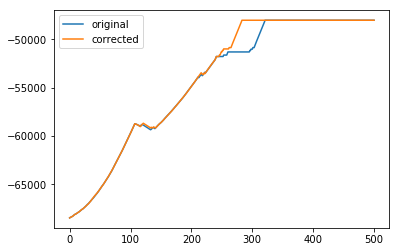

In [656]:
plt.plot(logp_list, label='original')
plt.plot(logp_list_corr, label='corrected')
plt.legend()
plt.show()

In [651]:
logp_list[-1], logp_list_corr[-1]

(<tf.Tensor: shape=(), dtype=float32, numpy=-48035.08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-48035.08>)

In [652]:
corr_obj.corr

array([[   0.        ,    0.        , -396.32006836],
       [   0.        ,    0.        , -335.13375854],
       [ 323.85479736,  -28.7387085 ,    0.        ]])

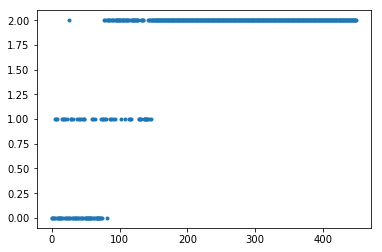

In [653]:
plt.plot(tf.argmax(Z, axis=-1), '.')

Now let's try locally balanced proposal

In [659]:
?tf.keras.losses.MSE

In [662]:
tf.concat([tf.one_hot(np.ones(10), 3), tf.one_hot(np.zeros(10), 3)], axis=-1)

<tf.Tensor: shape=(10, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.]], dtype=float32)>

In [668]:
tf.reshape(tf.one_hot([[0,1],
           [1, 0]], 3), (2, -1))

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0.]], dtype=float32)>

In [669]:
class GCNCorrCalc:
    
    def __init__(self, classes, model, opt = tf.keras.optimizers.Adam, steps=1):
        self.classes = classes
        self.model = model
        self.opt = opt
        
    def get_features(self, Z):
        is_1 = tf.where(Z==1)[:, 1]
        is_0 = tf.where(Z==0)[:, 1]
        
        fro = tf.reshape(tf.stack([is_1 for _ in range(self.K-1)], axis=-1), (-1,))
        to = is_0
        
        x = tf.concat([tf.one_hot(fro, self.classes), tf.one_hot(to, self.classes)], axis=-1)
        return x[::2, :], x[1::2]
        
    def update(self, x, y):
        x = tf.reshape(tf.one_hot(x, self.classes), (2, -1))
        
        with tf.GradientTape()as tape:
            y_pred = self.model(x)
            loss = tf.keras.losses.MSE(y, y_pred)
        grads = tape.gradient(loss, model.parameters)
        self.opt.apply_gradients(zip(grads, model.parameters))
    
    def calc_corr(self, Z):
        gathered = self.model(self.get_features(Z))
        
        res = []
        count = 0
        for z in Z.numpy().flatten():
            if z == 1:
                res.append(0.)
            else:
                res.append(gathered[count])
                count += 1
        return np.array(res).reshape(Z.shape)

In [675]:
def calc_ahat(A):
    A_1 = A+np.eye(A.shape[0])
    D = tf.reduce_sum(A_1, axis=0)**(-0.5)
    return D[None, :] * A_1 * D[:, None]

In [676]:
calc_ahat(dense_A)

<tf.Tensor: shape=(450, 450), dtype=float32, numpy=
array([[0.05263158, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02941176, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04347826, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.008     , 0.00787499,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00787499, 0.00775194,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00793651]], dtype=float32)>

In [680]:
tf.range(100)[::2]

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98],
      dtype=int32)>

In [681]:
tf.range(100)[1::2]

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99],
      dtype=int32)>